# Підготовка даних

In [1]:
import tensorflow as tf
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping
from keras.utils import to_categorical, plot_model
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.applications import VGG16, ResNet50

In [2]:
labelEncoder = LabelEncoder()

In [3]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [4]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    zoom_range=0.25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

In [5]:
ROOT_DIR = './data/Chess'
IMAGE_SHAPE = (64, 64)
EPOCHS = 100
BATCH_SIZE = 64
TEST_SIZE = 0.2
AUGMENTED_IMAGES = 50
MAX_COLOR = 255.0

In [6]:
subfolders = [folder for folder in os.scandir(ROOT_DIR) if folder.is_dir()]

subfolders

[<DirEntry 'Bishop'>,
 <DirEntry 'Rook'>,
 <DirEntry 'Pawn'>,
 <DirEntry 'Knight'>,
 <DirEntry 'King'>,
 <DirEntry 'Queen'>]

In [7]:
images = []
labels = []
categories = []

for folder in subfolders:
    fnames = os.listdir(folder.path)
    categories.append(folder.name)

    for fname in fnames:
        path = os.path.join(folder.path, fname)
        image = cv2.imread(path)
        
        if image is None:
            print(f"Image {path} could not be read.")
            continue
    
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, IMAGE_SHAPE)
        image = image / MAX_COLOR

        images.append(image)
        labels.append(folder.name)

        generator = datagen.flow(np.expand_dims(image, axis=0) , batch_size=1)
        
        for _ in range(AUGMENTED_IMAGES):
            augmented_image = next(generator)[0]
            
            images.append(augmented_image)
            labels.append(folder.name)

    print('Total images in folder: ', folder.path, len(fnames))

images = np.array(images)
labels = np.array(labels)

total_images = len(images)

print('Total images: ', total_images, categories)

Image ./data/Chess/Bishop/00000095.gif could not be read.
Total images in folder:  ./data/Chess/Bishop 87
Total images in folder:  ./data/Chess/Rook 102
Total images in folder:  ./data/Chess/Pawn 107
Total images in folder:  ./data/Chess/Knight 106
Total images in folder:  ./data/Chess/King 76
Total images in folder:  ./data/Chess/Queen 78
Total images:  28305 ['Bishop', 'Rook', 'Pawn', 'Knight', 'King', 'Queen']


In [8]:
N_CLASSES = len(categories)
N_CLASSES

6

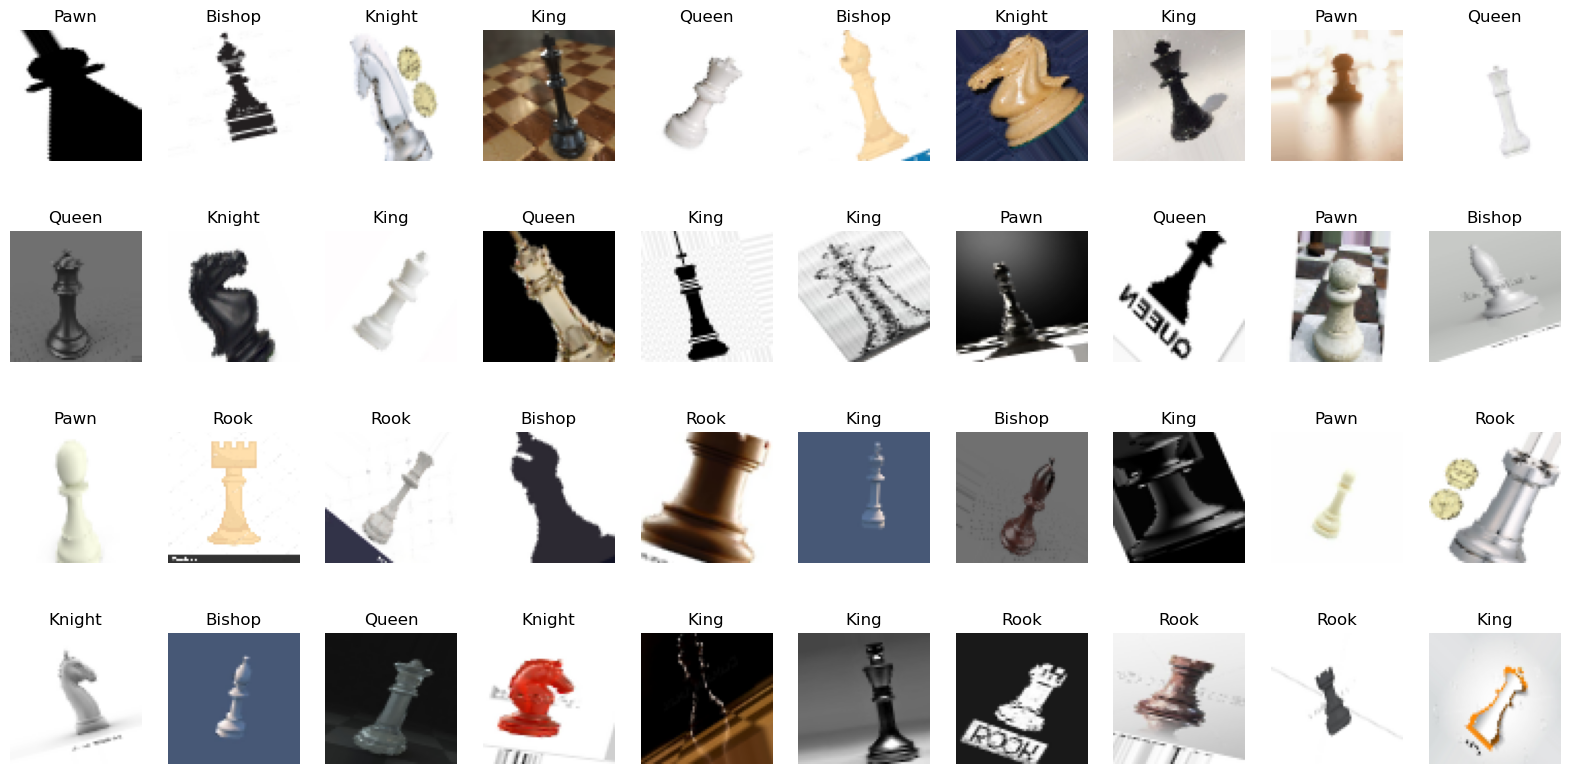

In [9]:
plt.figure(figsize=(20, 10))

for cnt, idx in enumerate(np.random.randint(0, len(images), 40)):
    plt.subplot(4, 10, cnt + 1)
    plt.imshow(images[idx], cmap='gray', vmin=0, vmax=255)
    plt.title(labels[idx])
    plt.axis(False)

# Нормалізація даних

In [10]:
labels_encoded = labelEncoder.fit_transform(labels)

(Text(0.5, 0, 'Traffic Sign ID'), Text(0, 0.5, 'Counts'))

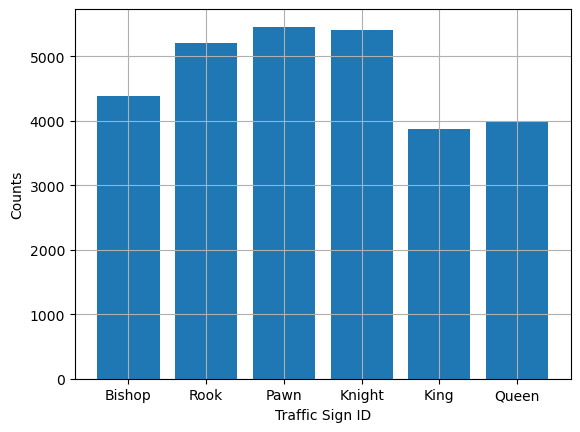

In [11]:
hist = Counter(labels)

plt.bar(hist.keys(), hist.values()), plt.grid(True)
plt.xlabel('Traffic Sign ID'), plt.ylabel('Counts')

# Перетворення міток у формат one-hot encoding

In [12]:
x_train, x_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=TEST_SIZE, shuffle=True)

y_train = to_categorical(y_train, num_classes=N_CLASSES)
y_test = to_categorical(y_test, num_classes=N_CLASSES)

len(x_train), len(y_train), len(x_test), len(y_test)


(22644, 22644, 5661, 5661)

# Створення базової моделі CNN

In [13]:
INPUT_SHAPE = (IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3)

In [14]:
model = Sequential([
    Input(shape=INPUT_SHAPE), 
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(N_CLASSES, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │       110,598 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203,846 (796.27 KB)

 Trainable params: 203,846 (796.27 KB)

 Non-trainable params: 0 (0.00 B)

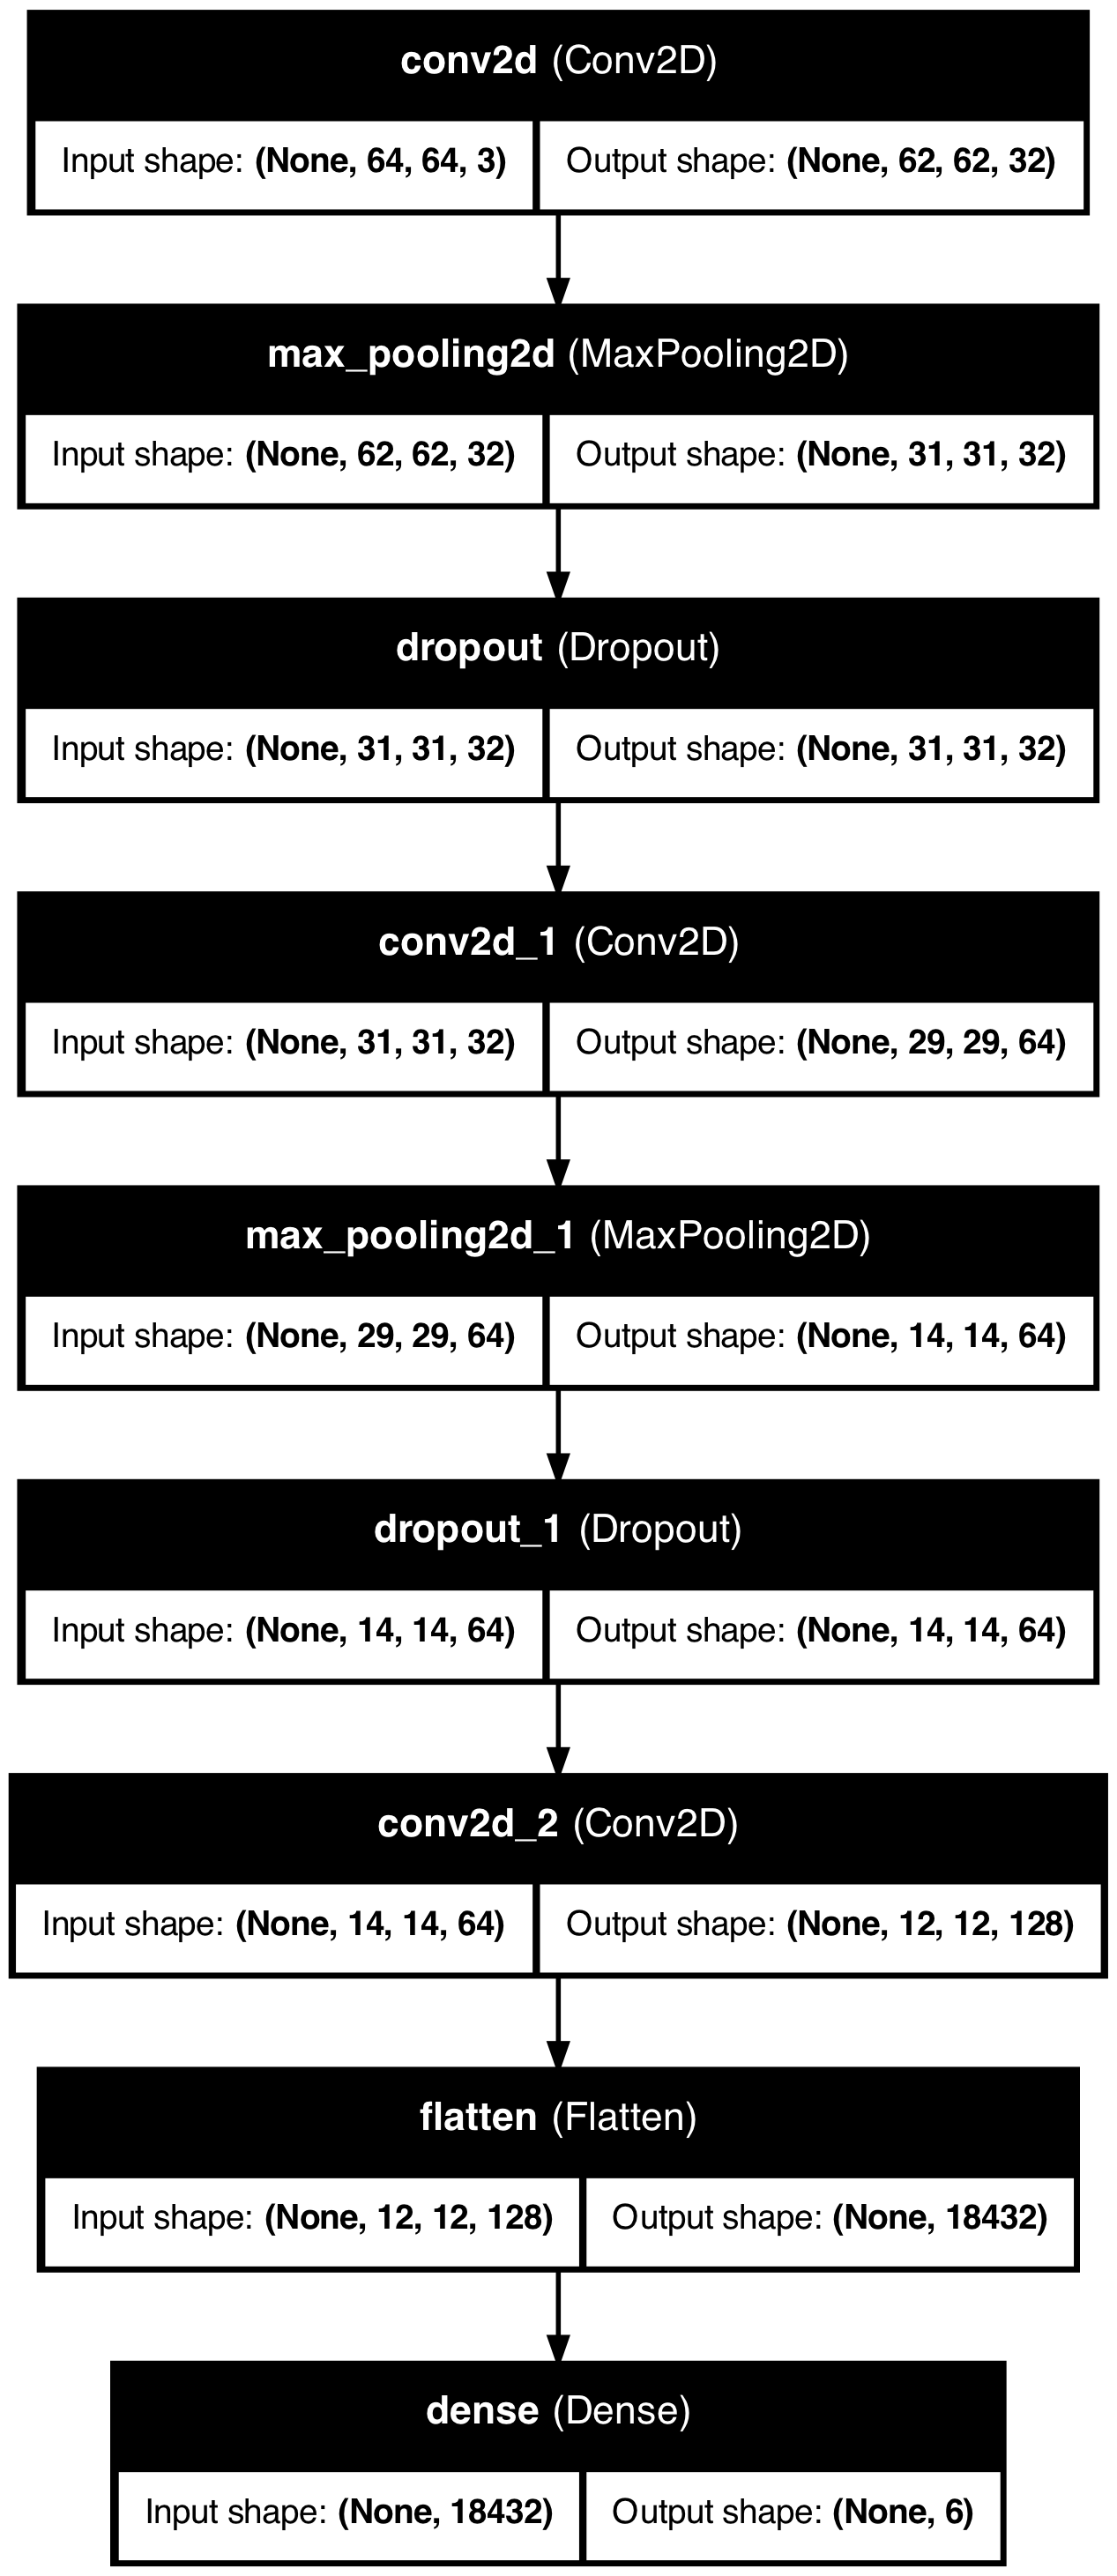

In [15]:
model.summary()

plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)


In [19]:
history = model.fit(x_train, y_train, epochs=EPOCHS, validation_data=(x_test, y_test), batch_size=BATCH_SIZE) #, callbacks=[earlyStopping])

Epoch 1/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.8698 - loss: 0.3675 - val_accuracy: 0.8059 - val_loss: 0.5908
Epoch 2/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.8921 - loss: 0.3025 - val_accuracy: 0.8126 - val_loss: 0.5855
Epoch 3/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9059 - loss: 0.2688 - val_accuracy: 0.8053 - val_loss: 0.6138
Epoch 4/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9231 - loss: 0.2218 - val_accuracy: 0.8202 - val_loss: 0.6163
Epoch 5/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9240 - loss: 0.2184 - val_accuracy: 0.8262 - val_loss: 0.6290
Epoch 6/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9333 - loss: 0.1907 - val_accuracy: 0.8205 - val_loss: 0.6212
Epoch 7/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9416 - loss: 0.1693 - val_accuracy: 0.8283 - val_loss: 0.6636
Epoch 8/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9472 - loss: 0

In [20]:
def draw_history(history):
      history_data = history.history
      epochs = range(len(history_data['loss']))
      plt.figure(figsize=(20, 8))
      plt.subplot(121)
      plt.plot(epochs, history_data['loss'], '.-', epochs, history_data['val_loss'], '.-')
      plt.grid(True)
      plt.xlabel('epochs')
      plt.ylabel('loss')
      plt.legend(['Train', 'Validation'])

      plt.subplot(122)
      plt.plot(epochs, history_data['accuracy'], '.-', epochs, history_data['val_accuracy'], '.-')
      plt.grid(True)
      plt.xlabel('epochs')
      plt.ylabel('Accuracy')
      plt.legend(['Train', 'Validation'])

      print('Accuracy:', (history_data['accuracy'][-1])) 
      print('Loss:', (history_data['loss'][-1]))

Accuracy: 0.987899661064148
Loss: 0.04196597635746002


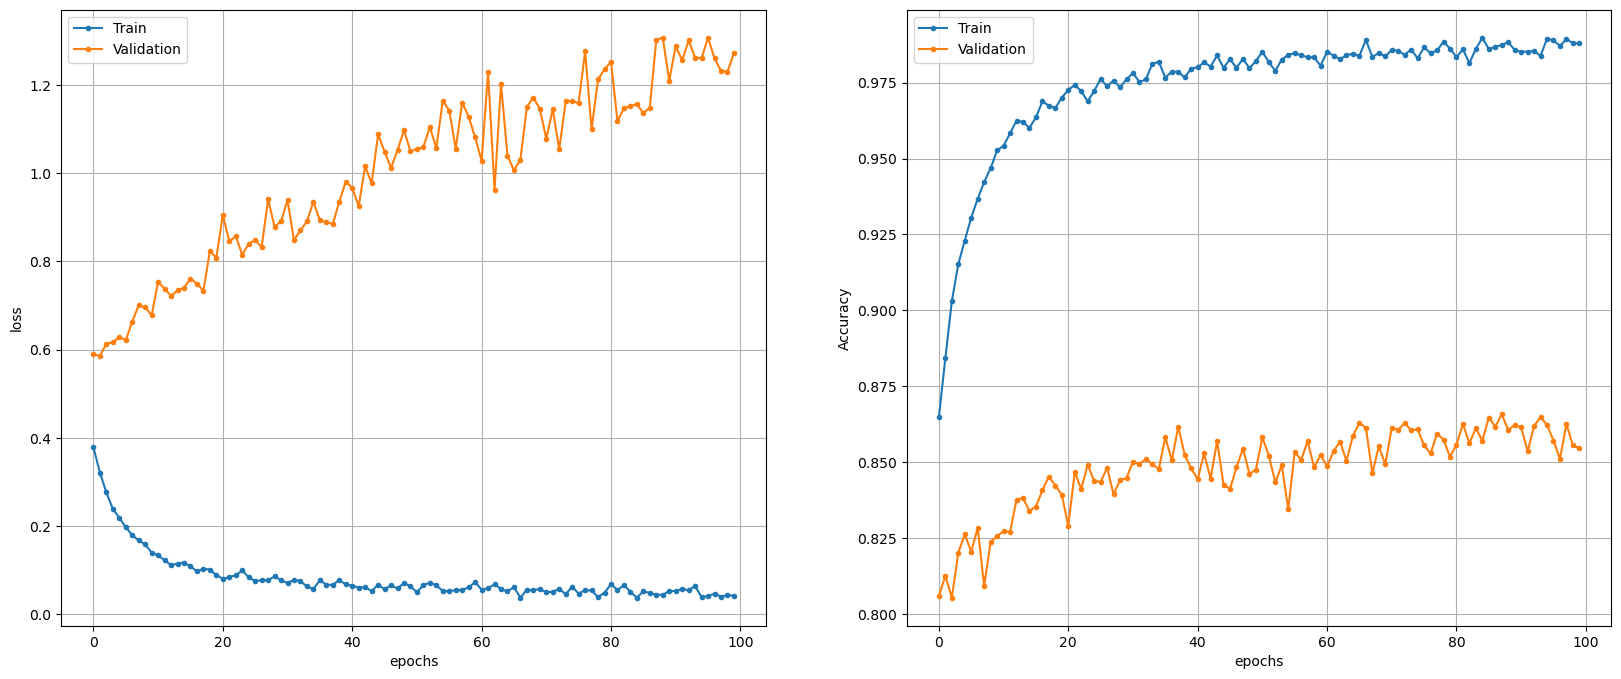

In [21]:
draw_history(history)

First run (original set)
![First](history/1.png)

Second run (early stopping)
![Second](history/2.png)

In [22]:
loss, metric = model.evaluate(x_test, y_test)

print('Test loss:', loss)
print('Test metric:', metric)

177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8537 - loss: 1.2816
Test loss: 1.272568941116333
Test metric: 0.8546193242073059


In [23]:
predictions = model.predict(x_test)
prediction = np.argmax(predictions, axis=1)
verification = np.argmax(y_test, axis=1)

177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


In [24]:
prediction == verification
correct = np.sum(prediction == verification)
total = len(prediction)

print('Correct predictions:', correct)
print('Incorrect predictions:', total - correct)
print('Total predictions:', total)
print('Accuracy:', correct / total)

Correct predictions: 4838
Incorrect predictions: 823
Total predictions: 5661
Accuracy: 0.8546193252075605


# Використання попередньо навчених моделей VGG16 та ResNet

# Завантаження попередньо навчених моделей без верхніх шарів

In [25]:
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

# Додавання верхніх шарів для класифікації

In [26]:
def create_model(base_model):
    outputs = base_model.output
    outputs = GlobalAveragePooling2D()(outputs)
    outputs = Dense(128, activation='relu')(outputs)
    outputs = Dense(N_CLASSES, activation='softmax')(outputs)
    model = Model(inputs=base_model.input, outputs=outputs)
    
    return model

In [27]:
model_vgg = create_model(base_model_vgg)
model_resnet = create_model(base_model_resnet)

# Компіляція моделей

In [28]:
model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Навчання моделей

In [29]:
history_vgg = model_vgg.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), batch_size=BATCH_SIZE)
history_resnet = model_resnet.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), batch_size=BATCH_SIZE)

Epoch 1/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 318s 895ms/step - accuracy: 0.1911 - loss: 1.8436 - val_accuracy: 0.1910 - val_loss: 1.7824
Epoch 2/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 321s 907ms/step - accuracy: 0.1929 - loss: 1.7803 - val_accuracy: 0.1910 - val_loss: 1.7824
Epoch 3/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 326s 922ms/step - accuracy: 0.1887 - loss: 1.7826 - val_accuracy: 0.1910 - val_loss: 1.7826
Epoch 4/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 322s 911ms/step - accuracy: 0.1948 - loss: 1.7824 - val_accuracy: 0.1947 - val_loss: 1.7821
Epoch 5/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 457s 1s/step - accuracy: 0.1909 - loss: 1.7829 - val_accuracy: 0.1910 - val_loss: 1.7820
Epoch 6/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 313s 885ms/step - accuracy: 0.1967 - loss: 1.7806 - val_accuracy: 0.1947 - val_loss: 1.7821
Epoch 7/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 328s 927ms/step - accuracy: 0.1961 - loss: 1.7812 - val_accuracy: 0.1910 - val_loss: 1.7823
Epoch 8/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 333s 942ms/step - accuracy: 0.1909 - lo

Accuracy: 0.9808779358863831
Loss: 0.06059592589735985


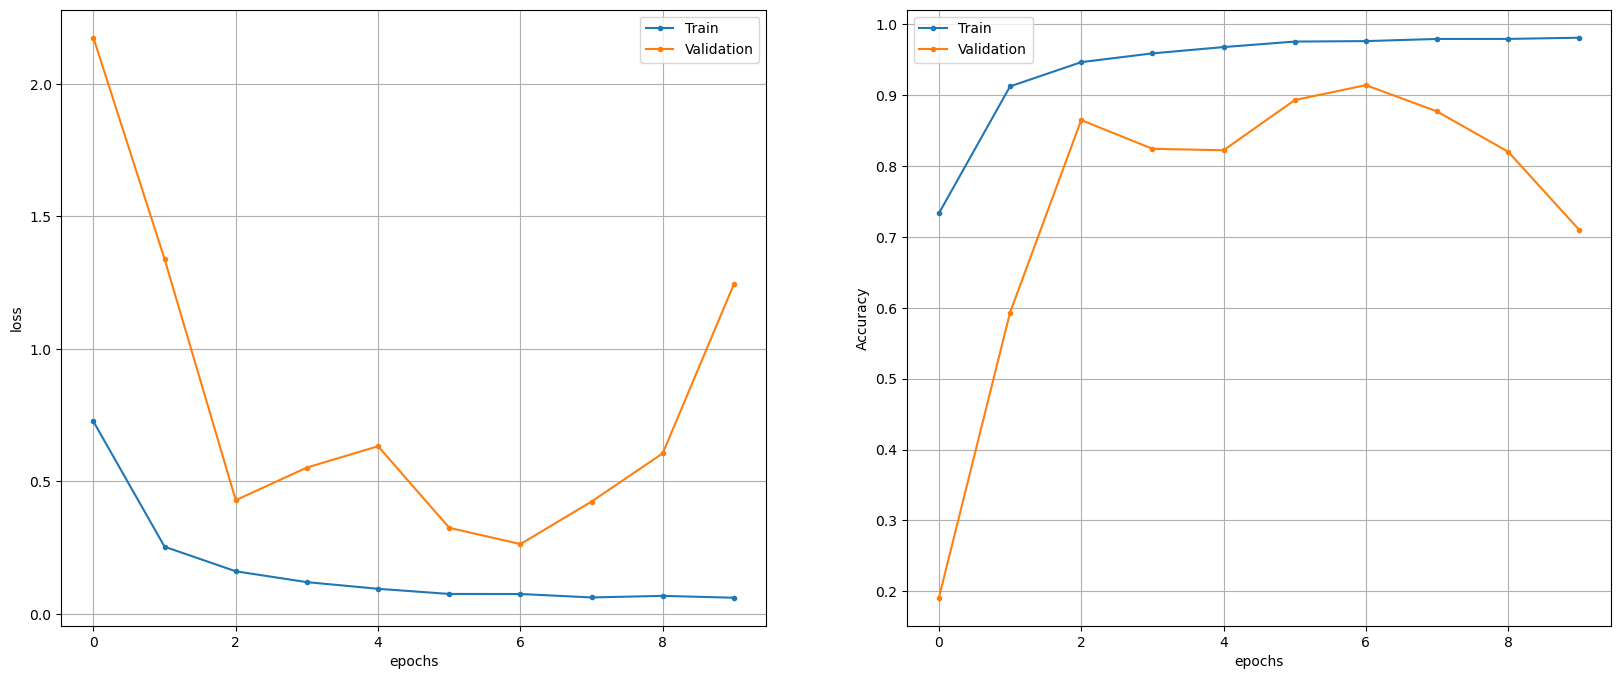

In [30]:
draw_history(history_resnet)

Accuracy: 0.18879173696041107
Loss: 1.7820795774459839


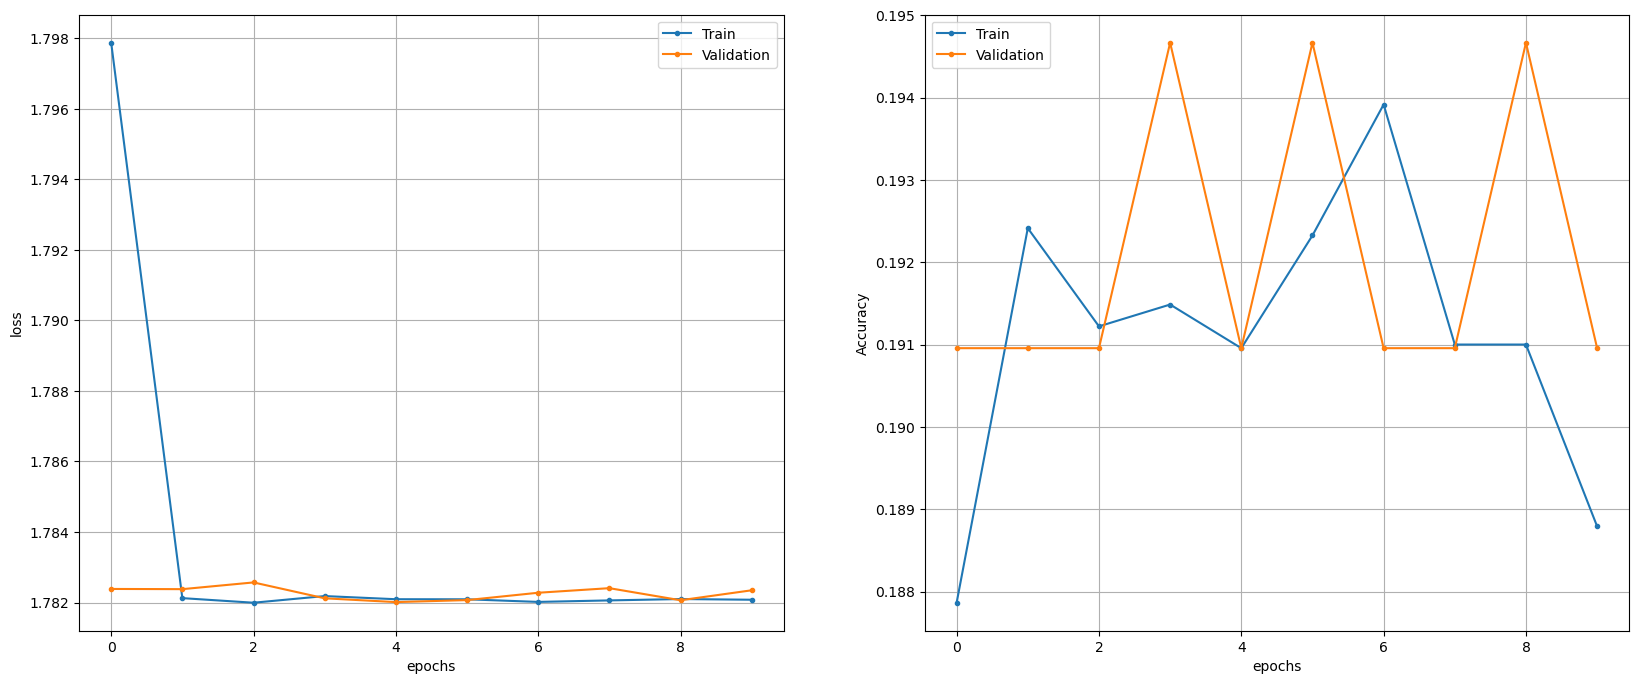

In [31]:
draw_history(history_vgg)

# Використання моделі YOLO для детекції об'єктів

# Завантаження попередньо навчених вагів YOLO та конфігурації

In [32]:
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

error: OpenCV(4.10.0) /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_81ng91bl78/croot/opencv-suite_1738943359148/work/modules/dnn/src/darknet/darknet_importer.cpp:210: error: (-212:Parsing error) Failed to open NetParameter file: yolov3.cfg in function 'readNetFromDarknet'


# Функція для завантаження зображення та детекції об'єктів

In [ ]:
'''
def detect_objects(image_path):
    img = cv2.imread(image_path)
    height, width = img.shape[:2]
    
    blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)
    
    class_ids = []
    confidences = []
    boxes = []
    
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            confidence = confidences[i]
            color = colors[class_ids[i]]
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
            cv2.putText(img, label + " " + str(round(confidence, 2)), (x, y + 30), cv2.FONT_HERSHEY_PLAIN, 3, color, 3)
    
    cv2.imshow("Image", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
'''

# Використання функції для детекції об'єктів

In [ ]:
# detect_objects("")

# Оцінка моделей

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)

print('Test loss:', loss)
print('Test accuracy:', accuracy)